Math 5750/6880: Mathematics of Data Science \
Project 3

# 1. Fashion-MNIST image classification using sklearn

In [34]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [36]:
def run_configuration(config):
    mlp = MLPClassifier(**config)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    test_item = {"config":config, "accuracy":accuracy_score(y_test, y_pred)}
    return test_item

In [37]:
import random
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
global population

config_ranges = {
    "hidden_layer_sizes": [(100,), (50), (10, 10), (150)],
    "max_iter": [7],
    "alpha": [1e-3, 1e-4, 1e-5],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [0.05, 0.1, 0.15],
    "activation": ['relu', 'logistic', 'tanh'],
    "early_stopping": [True, False],
    "random_state": [1, 2]
}
numerical_keys = {"alpha", "learning_rate_init"}
all_keys = list(config_ranges.keys())
mutable_keys = [key for key in all_keys if len(config_ranges[key]) > 1]

mutant_rate = 1/20
max_population = 16
generations = 8
births_per_generation = 8
tournament_size = 5
population = []

def sort_population():
    global population
    population = sorted(population, key=lambda item: -item["accuracy"])

def add_to_population(config):
    result = run_configuration(config)
    if result not in population:
       population.insert(1, result)

def random_tournament(ignore={}):
    volunteers = [body for body in population if body != ignore]
    return max(random.sample(volunteers, min(len(volunteers), tournament_size)), key=lambda body: body["accuracy"])

def reproduce(left_body, right_body):
    new_config = left_body["config"].copy()
    for each_key in random.sample(all_keys, random.randint(0, len(all_keys))):
        new_config[each_key] = right_body["config"][each_key]
    for each_key in mutable_keys:
        if random.uniform(0, 1) < mutant_rate:
            if each_key in numerical_keys:
                new_config[each_key] *= random.uniform(0.7, 1.3)
            else:
                new_config[each_key] = random.choice([each for each in config_ranges[each_key] if each != new_config[each_key]])

    return new_config

def cull_population():
    sort_population()
    global population
    population = population[:max_population]

def init_population():
    for _ in range(0, max_population):
        new_config = {}
        for each_key in config_ranges:
            new_config[each_key] = random.choice(config_ranges[each_key])
        add_to_population(new_config)

def display_fitness(generation):
    scores = list(map(lambda body: body["accuracy"], population))
    print("generation", generation, "best", max(scores), "avg", sum(scores) / len(scores))

# Filter out ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

if False:
    init_population()
    display_fitness(0)
    for generation in range(1, generations + 1):
        for _ in range(0, births_per_generation):
            left_body = random_tournament()
            right_body = random_tournament(left_body)
            add_to_population(reproduce(left_body, right_body))
        cull_population()
        display_fitness(generation)

In [5]:

for each_body in population: print(each_body)



In [44]:
sampling = {
    "Best": {'config': {'hidden_layer_sizes': (100,), 'max_iter': 7, 'alpha': 0.0001, 'solver': 'sgd', 'learning_rate_init': 0.15177829962856074, 'activation': 'logistic', 'early_stopping': False, 'random_state': 2}, 'accuracy': 0.8856},
    "Tanh": {'config': {'hidden_layer_sizes': (100,), 'max_iter': 7, 'alpha': 0.0001, 'solver': 'sgd', 'learning_rate_init': 0.1, 'activation': 'tanh', 'early_stopping': False, 'random_state': 1}, 'accuracy': 0.8743},
    "Early Stop, Low Alpha, 0.1 Learning Rate": {'config': {'hidden_layer_sizes': (100,), 'max_iter': 7, 'alpha': 0.00010938909086935239, 'solver': 'sgd', 'learning_rate_init': 0.1, 'activation': 'logistic', 'early_stopping': True, 'random_state': 2}, 'accuracy': 0.8757},
    "150 Nodes": {'config': {'hidden_layer_sizes': 150, 'max_iter': 7, 'alpha': 0.0001, 'solver': 'sgd', 'learning_rate_init': 0.15, 'activation': 'logistic', 'early_stopping': False, 'random_state': 2}, 'accuracy': 0.8824},
    "multilayer": {'config': {'hidden_layer_sizes': (20, 20), 'max_iter': 12, 'alpha':1e-4, 'solver': 'sgd', 'learning_rate_init': 0.1, 'activation': 'logistic', 'early_stopping': False, 'random_state': 1}, 'accuracy': 0.8586},
}

Running simulation for: Best


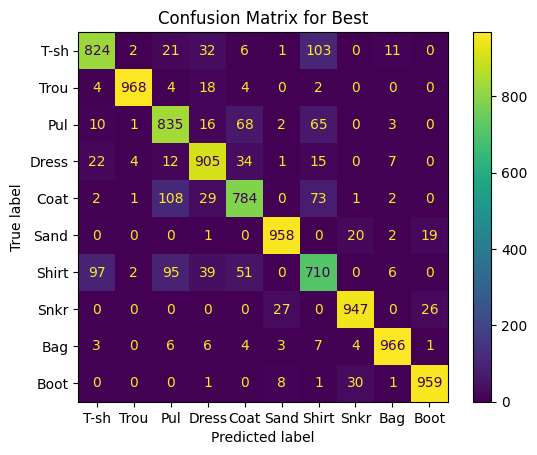

Running simulation for: Tanh


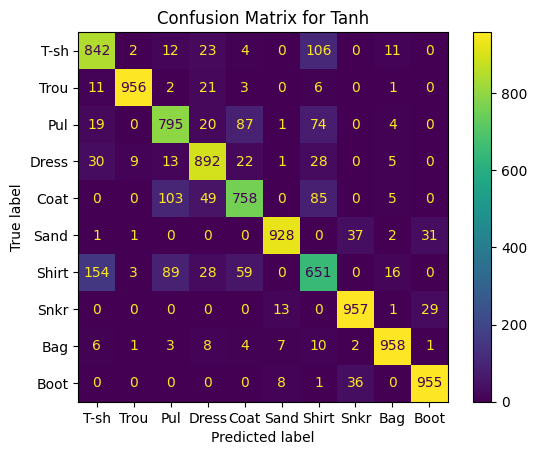

Running simulation for: Early Stop, Low Alpha, 0.1 Learning Rate


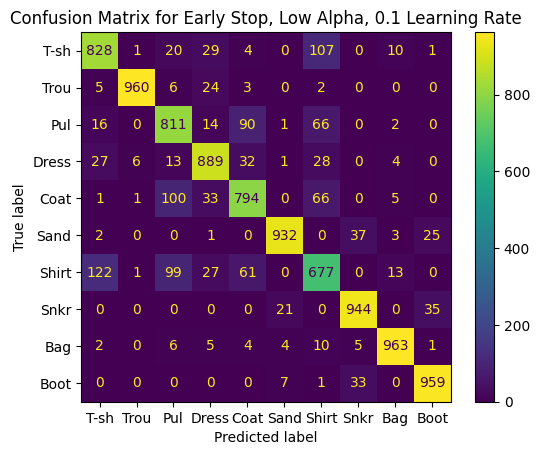

Running simulation for: 150 Nodes


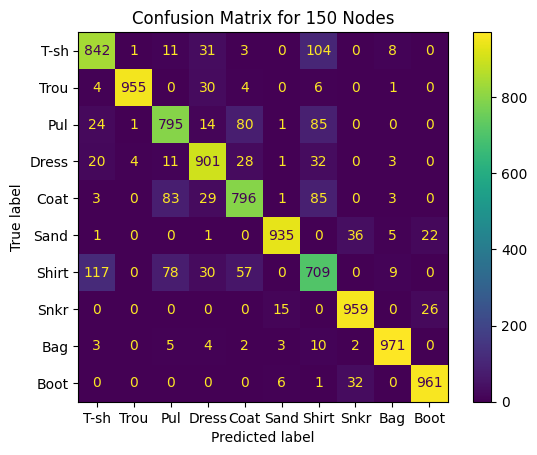

Running simulation for: multilayer


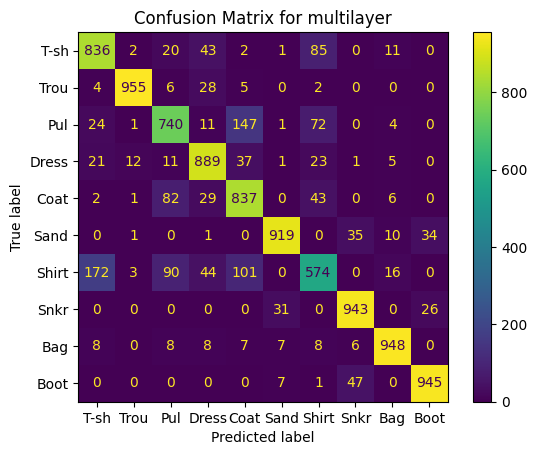


Training Times:
Best: 13.6811 seconds
Tanh: 6.9426 seconds
Early Stop, Low Alpha, 0.1 Learning Rate: 5.4294 seconds
150 Nodes: 9.2992 seconds
multilayer: 5.7623 seconds


In [41]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

results = {}
class_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
abbreviated_labels = ['T-sh', 'Trou', 'Pul', 'Dress', 'Coat', 'Sand', 'Shirt', 'Snkr', 'Bag', 'Boot']

if True:
    for name, item in sampling.items():
        print(f"Running simulation for: {name}")
        start_time = time.time()
        mlp = MLPClassifier(**item["config"])
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        end_time = time.time()
        training_time = end_time - start_time

        cm = confusion_matrix(y_test, y_pred)

        # Display confusion matrix as a plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=abbreviated_labels)
        disp.plot()
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "training_time": training_time
        }

# Print training times
print("\nTraining Times:")
for name, result in results.items():
    print(f"{name}: {result['training_time']:.4f} seconds")

# 3. Fashion-MNIST image classification  using pytorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# In colab, you should ``change runtime type'' to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# your code here

Using device: cuda


In [9]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import torch
from torch.utils.data import TensorDataset, DataLoader

def basic_data_process(data):
    train, test = data
    X_train, y_train = train
    X_test, y_test = test
    return ((X_train.astype("float32") / 255.0)[:, None, :, :], y_train.astype(np.int64), (X_test.astype("float32")  / 255.0)[:,  None, :, :], y_test.astype(np.int64))

def get_loaders(data):
    X_train, y_train, X_test, y_test = data
    X_tr, X_val = X_train[:50000], X_train[50000:]
    y_tr, y_val = y_train[:50000], y_train[50000:]
    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_tr),  torch.from_numpy(y_tr)), batch_size=128, shuffle=True)
    val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),   batch_size=256, shuffle=False)
    test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),  batch_size=256, shuffle=False)
    return {
        'train':train_loader,
        'val':val_loader,
        'test':test_loader
    }

loaders = get_loaders(basic_data_process(fashion_mnist.load_data()))

In [10]:
model_types = {
    'basic linear': {
        'epochs': 10,
        'layers': [
            ['Flatten', []],
            ['Linear', [28 * 28, 10]]
        ],
    },
    'linear with relu': {
        'epochs': 10,
        'layers': [
            ['Flatten', []],
            ['Linear', [28 * 28, 28 * 28]],
            ['ReLU', []],
            ['Linear', [28 * 28, 10]]
        ],
    },
    'linear with sigmoid': {
        'epochs': 10,
        'layers': [
            ['Flatten', []],
            ['Linear', [28 * 28, 28 * 28]],
            ['Sigmoid', []],
            ['Linear', [28 * 28, 10]]
        ],
    },
    'linear with relu, more epochs': {
        'epochs': 20,
        'layers': [
            ['Flatten', []],
            ['Linear', [28 * 28, 28 * 28]],
            ['ReLU', []],
            ['Linear', [28 * 28, 10]]
        ],
    },
    'conv2d alone': {
        'epochs': 10,
        'layers': [
            ['Conv2d', [1, 8, 3, 1, 1]],
            ['Flatten', []],
            ['LazyLinear', [10]],
            ['ReLU', []],
        ],
    },
    'conv2d with pool': {
        'epochs': 10,
        'layers': [
            ['Conv2d', [1, 8, 3, 1, 1]],
            ['MaxPool2d', [3, 1, 1]],
            ['Flatten', []],
            ['LazyLinear', [10]],
        ],
    },
    'conv2d with relu and pool': {
        'epochs': 10,
        'layers': [
            ['Conv2d', [1, 8, 3, 1, 1]],
            ['ReLU', []],
            ['MaxPool2d', [3, 1, 1]],
            ['ReLU', []],
            ['Flatten', []],
            ['LazyLinear', [10]],
        ],
    },
}

class GenericNN(nn.Module):
    def __init__(self, config):
        super(GenericNN, self).__init__()
        self.epochs = config['epochs']
        self.num_layers = len(config['layers'])
        for each_index, each_layer in enumerate(config['layers']):
            setattr(self, 'layer_' + str(each_index), getattr(nn, each_layer[0])(*each_layer[1]))

    def forward(self, x):
        for each_index in range(0, self.num_layers):
            x = getattr(self, 'layer_' + str(each_index))(x)

        return x


In [11]:
def train_model(model, optimizer, criterion, train_loader):
    for epoch in range(model.epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [12]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [13]:
model = GenericNN(model_types['basic linear']).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
#train_model(model, optimizer, criterion, loaders['train'])

In [15]:
print("Validation:", evaluate_model(model, loaders['val']))
print("Test:", evaluate_model(model, loaders['test']))

Validation: 0.1009
Test: 0.0971


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import os
import numpy as np

# ImageNet mean and standard deviation for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class FashionMNISTResNetDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def resnet_data_process(data):
    train, test = data
    X_train, y_train = train
    X_test, y_test = test
    X_test = X_test.reshape(-1, 28, 28)

    X_tr, X_val = X_train[:50000], X_train[50000:]
    y_tr, y_val = y_train[:50000], y_train[50000:]


    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

    train_dataset = FashionMNISTResNetDataset(X_tr, y_tr, transform=transform)
    val_dataset = FashionMNISTResNetDataset(X_val, y_val, transform=transform)
    test_dataset = FashionMNISTResNetDataset(X_test, y_test, transform=transform)

    return (train_dataset, test_dataset, val_dataset)


def get_resnet_loaders(train, test, val):
    train, test, val = data
    return {
        'train':DataLoader(train, batch_size=128, shuffle=True),
        'test':DataLoader(test, batch_size=256, shuffle=False),
        'val':DataLoader(val, batch_size=256, shuffle=True)
    }

loaders2 = get_resnet_loaders(resnet_data_process(fashion_mnist.load_data()))

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.LazyLinear(10)

setattr(model, 'epochs', 10)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # Only optimize the new layer
criterion = nn.CrossEntropyLoss()

train_model(model, optimizer, criterion, loaders2['train'])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
print("Validation:", evaluate_model(model, loaders2['val']))
print("Test:", evaluate_model(model, loaders2['test']))

Validation: 0.8642
Test: 0.8648
